In [5]:
# Pacotes usados
import numpy as np
from typing import Sequence
import matplotlib.pyplot as plt
import numpy as np
from scipy.integrate import solve_ivp

Modelo S-System:

$$
\begin{equation}
    \frac{dX_i}{dt} = \alpha_i \prod_{j=1}^{N} X_j^{g_{ij}} - \beta_i \prod_{j=1}^{N} X_j^{h_{ij}}, \qquad  i = 1, \, 2, \, \dots, \, N
\end{equation}
$$


In [1]:
# Modelo S-System
def gs_system_ode(t, X, alpha, beta, g, h):
    r"""
    Autor: Pedro Siscato

    Define o modelo dinâmico de um S-system genérico.

    Esta função calcula as derivadas temporais das concentrações para um
    sistema de N espécies moleculares interagindo, governado pelo formalismo
    do S-system — uma representação não linear em lei de potência comumente
    usada em teoria de sistemas bioquímicos.

    O sistema de EDOs modelado é:

        dX_i/dt = α_i * ∏_j X_j**(g_ij) - β_i * ∏_j X_j**(h_ij),   para i = 1,...,N

    onde:
    - X_i: concentração da espécie i no tempo t;
    - dX_i/dt: taxa líquida de mudança de X_i (produção menos degradação);
    - alpha_i, beta_i: constantes de taxa não-negativas para produção e degradação, respectivamente;
    - g_ij: ordens cinéticas reais descrevendo a influência de X_j sobre X_i na produção;
    - h_ij: ordens cinéticas reais descrevendo a influência de X_j sobre X_i na degradação.

    Interpretação dos parâmetros:
    - Se g_ij > 0, a espécie j ativa a produção de i;
    - Se g_ij < 0, a espécie j inibe a produção de i;
    - Se g_ij = 0, a espécie j não tem efeito sobre a produção de i;
    - A mesma interpretação se aplica para h_ij em termos de degradação.

    Parâmetros de entrada:
    t     - Tempo atual (escalar). Não usado explicitamente, incluído para compatibilidade com solvers de EDOs.
    X     - Vetor coluna (N×1) das concentrações das espécies em t.
    alpha - Vetor coluna (N×1) das constantes de taxa de produção.
    beta  - Vetor coluna (N×1) das constantes de taxa de degradação.
    g     - Matriz (N×N) das ordens cinéticas para produção.
    h     - Matriz (N×N) das ordens cinéticas para degradação.

    Saída:
    dXdt  - Vetor coluna (N×1) com as derivadas temporais das concentrações.
    """

    N = len(X)
    dXdt = np.zeros(N)
    for i in range(N):
        prod_term = np.prod(X ** g[i, :])
        degr_term = np.prod(X ** h[i, :])
        dXdt[i] = alpha[i] * prod_term - beta[i] * degr_term
    return dXdt


In [4]:
# Função para plotar gráfico de linhas
def plot_lines(
    x: np.ndarray,
    ys: np.ndarray,
    labels: Sequence[str] | None = None,
    colors: Sequence[str] | None = None,
    title: str = "",
    xlabel: str = "X-axis",
    ylabel: str = "Y-axis",
    grid: bool = False,
    linewidth: Sequence[float] | float = 2,
    legend_fontsize: int = 16,
    ticks_fontsize: int = 16,
    title_fontsize: int = 20,
    labels_fontsize: int = 18,
    specify_x_lim: bool = False,
    specify_y_lim: bool = False,
    specify_ticks: bool = False,
    legend: bool = False,
    x_lim: tuple[float, float] = (0, 1),
    y_lim: tuple[float, float] = (0, 1),
    y_step_ticks: float = 0.1,
    x_step_ticks: float = 0.1,
    legend_loc: str = "best",
    font_name: str = "Times New Roman",
):
    default_colors = [
        "#090D85",  # blue
        "#A8150F",  # red
        "#18863D",  # green
        "#820186",  # magenta
        "#FF353C",  # red_2
        "#017D86",  # dark_cyan
        "#EAC703",  # yellow
    ]

    plt.figure(figsize=(8, 8))
    num_lines = ys.shape[0]

    # Determina a lista de cores primária (a do usuário ou a padrão da função)
    primary_colors = list(colors) if colors is not None else default_colors
    # Verifica se a lista primária é suficiente
    if len(primary_colors) < num_lines:
        # Se não for, busca o ciclo de cores padrão do Matplotlib como fallback
        mpl_default_colors = plt.rcParams["axes.prop_cycle"].by_key()["color"]
        # Calcula quantas cores adicionais são necessárias
        num_fallback_colors_needed = num_lines - len(primary_colors)
        # Cria um ciclo com as cores de fallback para garantir que haja o suficiente
        fallback_cycle = mpl_default_colors * (
            num_fallback_colors_needed // len(mpl_default_colors) + 1
        )
        # Constrói a lista final de cores: primárias + fallback
        final_color_list = primary_colors + fallback_cycle[:num_fallback_colors_needed]
    else:
        # Se for suficiente, a lista final é apenas a lista primária (cortada no tamanho exato)
        final_color_list = primary_colors[:num_lines]

    for i in range(num_lines):
        y = ys[i, :]
        label = labels[i] if labels is not None else f"Linha {i + 1}"

        # Seleciona a cor apropriada para a linha atual
        color_to_use = final_color_list[i]

        plt.plot(
            x,
            y,
            label=label,
            color=color_to_use,
            # --------------------------------
            linewidth=linewidth[i] if isinstance(linewidth, Sequence) else linewidth,
        )

    plt.title(title, fontsize=title_fontsize, fontname=font_name)
    plt.xlabel(xlabel, fontsize=labels_fontsize, fontname=font_name)
    plt.ylabel(ylabel, fontsize=labels_fontsize, fontname=font_name)

    if grid:
        plt.grid(True, axis="y", linewidth=0.5, alpha=0.5)
    if not specify_x_lim:
        x_lim = (np.min(x), np.max(x))
        plt.xlim(x_lim)
    else:
        plt.xlim(x_lim)
    if not specify_y_lim:
        y_lim = (np.min(ys), np.max(ys))
        plt.ylim(y_lim)
    else:
        plt.ylim(y_lim)
    if legend:
        plt.legend(loc=legend_loc, prop={"family": font_name, "size": legend_fontsize})
    if not specify_ticks:
        x_step_ticks = (x_lim[1] - x_lim[0]) / 5
        y_min, y_max = y_lim
        y_step_ticks = (y_max - y_min) / 5

    plt.xticks(
        np.arange(x_lim[0], x_lim[1] + x_step_ticks, x_step_ticks),
        fontname=font_name,
        fontsize=ticks_fontsize,
    )
    plt.yticks(
        np.arange(y_min, y_max + y_step_ticks, y_step_ticks),
        fontname=font_name,
        fontsize=ticks_fontsize,
    )
    plt.tight_layout()
    plt.show()


Este é o exemplo 3.1.1 do artigo de Liu, Wu e Zhang (2014)
LIU, Li-Zhi; WU, Fang-Xiang; ZHANG, Wen-Jun. Estimating parameters of S-systems by an auxiliary function guided coordinate descent method. 
Systems Science & Control Engineering, v. 2, n. 1, p. 125–134, dez. 2014.
Solução encontrada com sucesso. Plotando resultados...


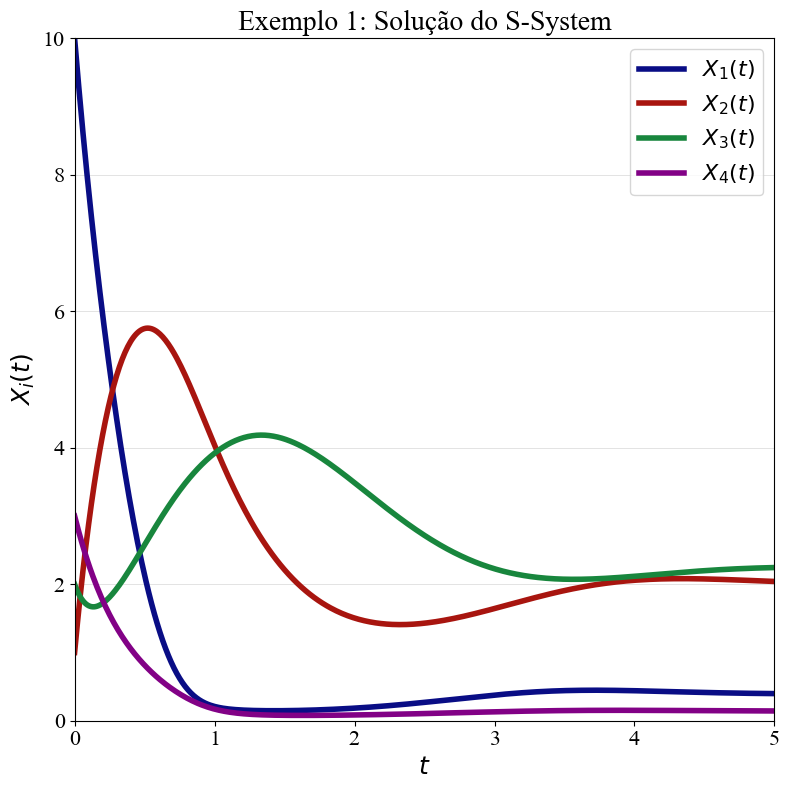

--- Simulação Exemplo 1 Concluída ---



In [8]:
print("Este é o exemplo 3.1.1 do artigo de Liu, Wu e Zhang (2014)")
print(
    "LIU, Li-Zhi; WU, Fang-Xiang; ZHANG, Wen-Jun. Estimating parameters of S-systems by an auxiliary function guided coordinate descent method. \nSystems Science & Control Engineering, v. 2, n. 1, p. 125–134, dez. 2014."
)
# Parâmetros e condições iniciais
alpha = np.array([12, 8, 3, 2])
beta = np.array([10, 3, 5, 6])
g = np.array([[0, 0, -0.8, 0], [0.5, 0, 0, 0], [0, 0.75, 0, 0], [0.5, 0, 0, 0]])
h = np.array([[0.5, 0, 0, 0], [0, 0.75, 0, 0], [0, 0, 0.5, 0.2], [0, 0, 0, 0.8]])
X0 = np.array([10, 1, 2, 3])
t_span = (0, 5)  # solve_ivp prefere t_span como uma tupla (início, fim)
t_eval = np.arange(t_span[0], t_span[1] + 0.01, 0.01)

# Chamada ao solver usando o método 'args' que é mais limpo
sol = solve_ivp(
    fun=gs_system_ode,
    t_span=t_span,
    y0=X0,
    t_eval=t_eval,
    args=(alpha, beta, g, h),  # Passando os parâmetros extras
    method="BDF",  # Método de Runge-Kutta de ordem 4(5)
)

# Plotando os resultados
if sol.success:
    print("Solução encontrada com sucesso. Plotando resultados...")
    plot_lines(
        x=sol.t,
        ys=sol.y,
        labels=[f"$X_{i + 1}(t)$" for i in range(sol.y.shape[0])],
        title="Exemplo 1: Solução do S-System",
        xlabel=r"$t$",
        ylabel=r"$X_i(t)$",
        grid=True,
        specify_y_lim=True,
        y_lim=(0, np.max(sol.y)),
        legend=True,
        linewidth=4,
    )
else:
    print("Ocorreu um erro ao resolver a EDO:", sol.message)

print("--- Simulação Exemplo 1 Concluída ---\n")